Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [1]:
#import Pkg; Pkg.add("Combinatorics")

In [2]:
using QuantumOptics
using NBInclude
using Einsum
using DataFrames
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")
# chern 
@nbinclude("Chern_utils.ipynb")

calc_all_states_H_mb_2 (generic function with 1 method)

# Parameters

In [3]:
param_dict=Dict{}()

LL = [3,3]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=LL[2]
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

# size of parameter space
N1 = 15
N2 = 15
dx=2*pi/N1
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

param_dict["Tx"] = Tx
param_dict["Ty"] = Ty;

# 1) Single Particle

In [4]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H1 = get_sp_op(basis, H_T)

EE, UU = eigenstates(dense(H1));

## 1.1) Single Particle Chern

In [5]:
param_dict["param_1"] = "Tx"
param_dict["param_2"] = "Ty"
EEA_0, UUA_0 = calc_all_states_H1(param_dict);

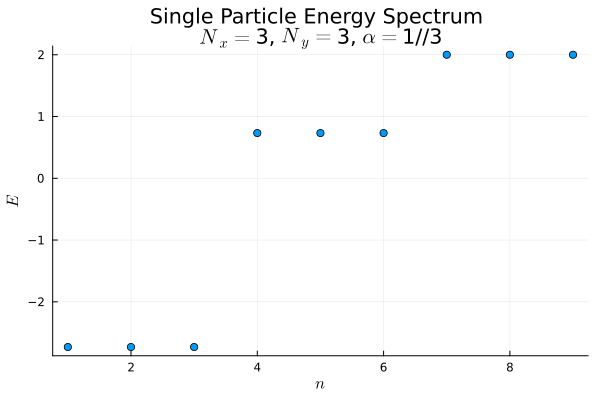

In [6]:
using Plots
using LaTeXStrings
scatter(real(EEA_0[1,1,:]),legend = false,title="Single Particle Energy Spectrum \n" 
                                                 *L"N_x="*"$(LL[1]), "*L"N_y="*"$(LL[2]), " 
                                                 *L"\alpha="*"$(p//q)", xlabel=L"n",ylabel=L"E")

In [7]:
EEA_0[1,1,:]

9-element Vector{Float64}:
 -2.7320508075688728
 -2.732050807568871
 -2.732050807568871
  0.7320508075688776
  0.7320508075688779
  0.7320508075688781
  1.9999999999999998
  1.9999999999999998
  2.0000000000000004

In [8]:
bands = [[1,3],[4,6],[7,9]]
#bands = [[1,4],[5,8],[9,12],[13,16]]
#bands = [[1,5],[6,10],[11,15],[16,20],[21,25]] # 5x5
Chern, F12list = calc_chern_bands(UUA_0, bands)
Chern

3-element Vector{Any}:
                 1.0 - 5.49690644759737e-16im
 -2.0000000000000004 - 7.098959396452245e-17im
  1.0000000000000002 - 3.373998197436821e-17im

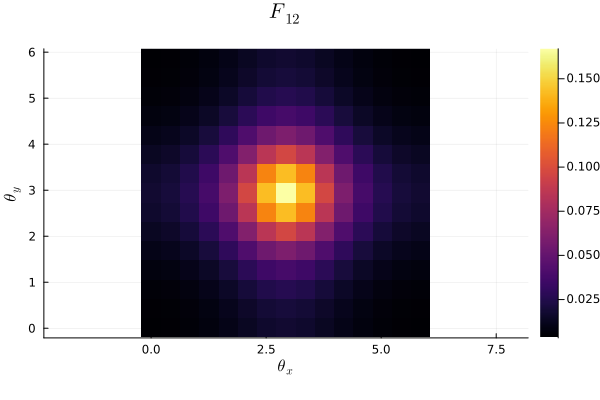

In [9]:
band_idx = 1
heatmap(Tx, Ty, imag(F12list[band_idx]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 2) Projected Single Particle

In [10]:
param_dict["sub_range"] = 1:3

#sub_states = get_subset_states(H1, param_dict["sub_range"]);
#subspace_proj, P, Pt = get_projector_op(basis, sub_states);
#H1_proj = get_subspace_op(H1, P, Pt);
#param_dict["subspace_proj"] = subspace_proj
#param_dict["projection"] = subspace_proj, P, Pt;

1:3

## 2.1) Projected Single Particle Chern

In [11]:
EEA, UUA = calc_all_states_H1(param_dict);

In [12]:
bands = [[1,3]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 1.0 - 5.49690644759737e-16im

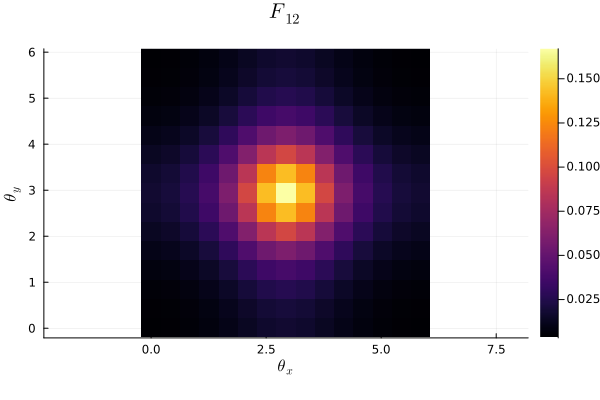

In [13]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 3) Many Body

In [10]:
delete!(param_dict, "sub_range");

In [11]:
PN = 2
param_dict["PN"] = PN
basis_mb = get_basis_mb(param_dict)
param_dict["basis_mb0"] = basis_mb

ManyBody(onebodybasis=NLevel(N=9), states:45)

## 3.1) Non-Interacting Many Body

In [12]:
H1_mb = get_mb_op(basis_mb, H1);

In [13]:
state_list = []
for state in param_dict["basis_mb"].occupations
    #println(findall(state.!=0))
    repr = Int64[]
    for oi in findall(state.!=0)
            push!(repr,repeat([oi],state[oi])...)
    end
    #println(repr)
    push!(state_list, repr)
end
param_dict["state_list0"]=state_list;
param_dict["state_list"]=state_list;

In [14]:
param_dict["dimH_mb"] = length(basis_mb)
param_dict["dimH_mb0"] = length(basis_mb)

EEA, UUA = calc_all_states_H_mb(param_dict);

In [15]:
#H_mb = get_H_mb(param_dict);

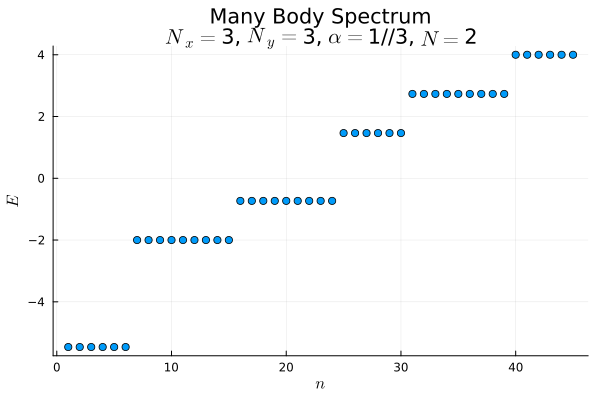

In [16]:
scatter(real(EEA[1,1,:]),legend=false,xlabel=L"n",ylabel=L"E")
#scatter!(real(EEA[1,1,:]))
title!("Many Body Spectrum\n" *L"N_x="*"$(LL[1]), "
                              *L"N_y="*"$(LL[2]), "
                              *L"\alpha="*"$(p//q), "
                              *L"N="*"$(PN)")

In [17]:
EEA[1,1,1:16]

16-element Vector{Float64}:
 -5.464101615137779
 -5.464101615137776
 -5.464101615137773
 -5.464101615137763
 -5.464101615137753
 -5.464101615137751
 -2.000000000000006
 -2.0000000000000013
 -2.0
 -1.999999999999999
 -1.9999999999999967
 -1.999999999999994
 -1.9999999999999927
 -1.999999999999991
 -1.999999999999991
 -0.7320508075688842

In [18]:
param_dict["basis_mb"]

ManyBody(onebodybasis=NLevel(N=9), states:45)

### 3.1.1) Non-Interacting Many Body Chern

In [19]:
#bands = [[1,6]]
bands = [[1,6], [7,15], [16,24], [25,30], [31,39], [40,45]]
#bands = [[1,5], [6,10], [11,15], [16,20], [21,25]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

6-element Vector{Any}:
   4.000000000000002 - 1.8453800169040938e-16im
 -2.9999999999999996 + 2.416972214297188e-17im
  1.9999999999999998 - 5.008096707905572e-16im
 -3.9999999999999996 - 2.4040917687571475e-16im
                -3.0 + 2.728328190499753e-17im
   4.000000000000001 + 8.328421858769421e-17im

In [20]:
sum(real(Chern))

3.1086244689504383e-15

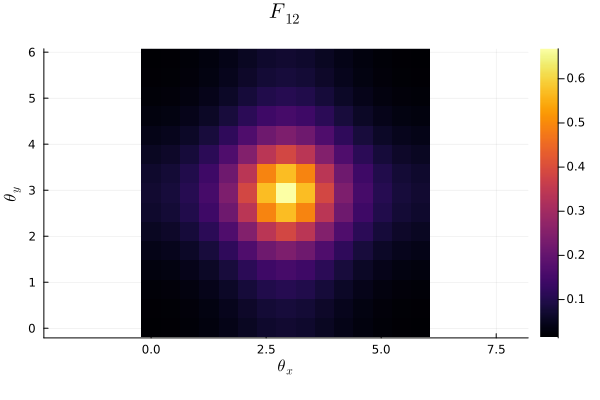

In [21]:
heatmap(Tx,Ty,imag(F12list[1]), title=L"F_{12}", 
        xlabel=L"\theta_x", ylabel=L"\theta_y", aspect_ratio=1)

### 3.1.2) Non-Interacting Projected Many Body Chern

In [26]:
param_dict["sub_range"] = 1:4

H_mb = get_H_mb(param_dict);

state_list = []
for state in param_dict["basis_mb"].occupations
    #println(findall(state.!=0))
    repr = Int64[]
    for oi in findall(state.!=0)
            push!(repr,repeat([oi],state[oi])...)
    end
    #println(repr)
    push!(state_list, repr)
end
param_dict["state_list"]=state_list;

In [ ]:
basis_mb = get_basis_mb(param_dict)

EEA, UUA = calc_all_states_H_mb(param_dict);

In [ ]:
scatter(real(EEA[1,1,:]),legend=false,xlabel=L"n",ylabel=L"E")
#scatter!(real(EEA[1,1,:]))
title!("Many Body Spectrum\n" *L"N_x="*"$(LL[1]), "
                              *L"N_y="*"$(LL[2]), "
                              *L"\alpha="*"$(p//q), "
                              *L"N="*"$(PN)")

In [ ]:
bands = [[1,6]]
Chern, F12list = calc_chern_bands(UUA, bands, true);
Chern

In [ ]:
heatmap(Tx,Ty,imag(F12list[1]), title=L"F_{12}", 
        xlabel=L"\theta_x", ylabel=L"\theta_y", aspect_ratio=1)

In [ ]:
param_dict["dimH_mb0"]

## 3.2) Interacting Many Body

In [22]:
delete!(param_dict, "sub_range");

In [23]:
param_dict["U"] = 2 # U=0 iken yukarıda ki ile aynı
H_Finite, H_Int = get_Finite_U(param_dict)
#param_dict["θθ"]=[ Tx[2], Ty[2] ]
#Ee, Uu = eigenenergies(dense(H_Finite)) ## Hofstadter MB in Julia.ipynb ile farklı!
EEA, UUA = calc_all_states_H_mb_Finite_U(param_dict);

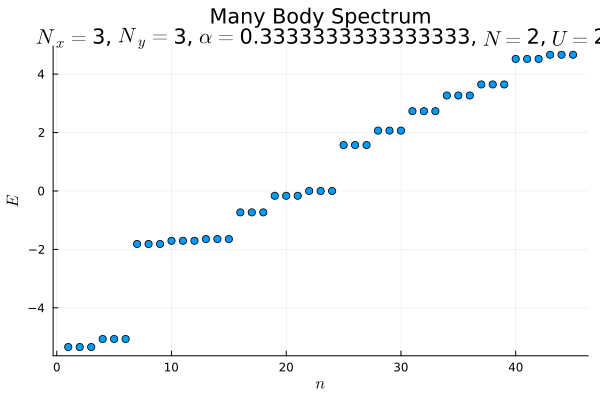

In [24]:
scatter(real(EEA[1,1,:]),legend=false,xlabel=L"n",ylabel=L"E")
#scatter!(real(EEA[15,15,:]))
title!("Many Body Spectrum\n"*L"N_x="*"$(LL[1]), "
                             *L"N_y="*"$(LL[2]), "
                             *L"\alpha="*"$(p/q), "
                             *L"N="*"$(PN), "
                             *L"U="*"$(param_dict["U"])")
#xlims!((0,5))

In [25]:
real(EEA[1,1,:])

45-element Vector{Float64}:
 -5.340971176014535
 -5.340971176014534
 -5.340971176014522
 -5.066168265618866
 -5.066168265618854
 -5.066168265618836
 -1.8128503544788677
 -1.8128503544788634
 -1.8128503544788632
 -1.7045703369311758
  ⋮
  3.64575131106459
  3.6457513110645907
  3.645751311064591
  4.519542897531034
  4.519542897531036
  4.519542897531036
  4.662503113875361
  4.662503113875362
  4.662503113875362

### 3.2.1) Interacting Many Body Chern

In [32]:
bands = [[1,6]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern
# Hofstadter MB in Julia dosyası Chern ilk bandı da +4 üretiyor!

1-element Vector{Any}:
 3.9999999999999996 + 7.643589697741961e-17im

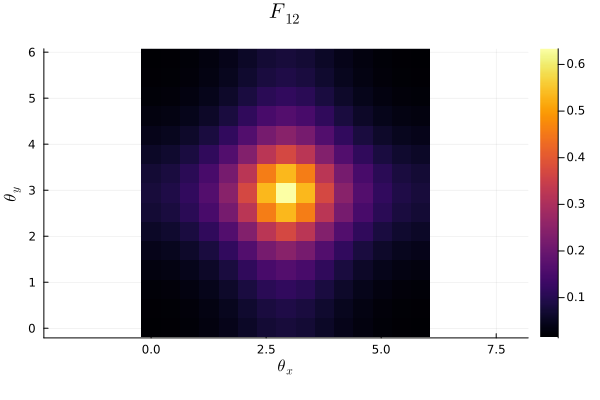

In [33]:
heatmap(Tx,Ty,imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 4) Projected Interacting Many Body

In [ ]:
param_dict["sub_range"] = 1:6;

In [ ]:
param_dict["PN_int"] = [0, 1, 2]
cut_off = last(param_dict["sub_range"])
H_Total_Intt, basis_cut_mb = proj_MB_Int(param_dict);

In [ ]:
EeE, UuU = eigenstates(dense((H_Total_Intt+H_Total_Intt')/2))
UuU_square = eigvecs(dense((H_Total_Intt+H_Total_Intt')/2).data)
EeE

In [ ]:
pn = 2
df = get_energies(pn, EeE, UuU, basis_cut_mb)
EE_res = Matrix(df)[:,2]

In [ ]:
function restricted_hubbard_states(filtered_E, UuU)
    number_of_states = length(EE_res)
    return UuU[:,1:number_of_states]
end
UU_res = restricted_hubbard_states(EE_res, UuU_square);

## 4.1) Projected Many Body Chern

In [ ]:
param_dict["dimH_mb_int"] = length(basis_cut_mb)
EE_res, UU_res = calc_all_states_H_mb_Int(param_dict);

In [ ]:
scatter(EE_res[1,1,:])
scatter!(EE_res[15,15,:])

In [ ]:
EE_res[1,1,:] # E'ler Hofstadter First Band Approximation dosyasında ki ile aynı

In [ ]:
bands = [[1,6]]
Chern, F12list = calc_chern_bands(UU_res[:,:,:,1:6], bands);
Chern

In [ ]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

In [ ]:
param_dict["θθ"] = [0, 0];

In [ ]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

get_H_mb(param_dict)

In [ ]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb_chern

In [ ]:
param_dict["dimH_mb"] = length(basis_mb_chern)

In [ ]:
param_dict["θθ"] = [0, 1.1];

In [ ]:
H_mb_Chern_basis = get_H_mb(param_dict); 

In [ ]:
# #H_T = get_Hofstadter_hamiltonian(param_dict);

# H1 = get_sp_op(basis, H_T);
# sub_states = get_subset_states(H1, param_dict["sub_range"])
# subspace_proj, P, Pt = get_projector_op(basis, sub_states);
# param_dict["projection"] = subspace_proj, P, Pt;

basis_mb_1 = get_basis_mb(param_dict);

In [ ]:
H_mb_1 = get_H_mb(param_dict);

In [ ]:
H_mb_Chern_basis == H_mb_1

In [ ]:
basis_mb_1

In [ ]:
basis_mb_chern

In [ ]:
U = get_mb_op(basis_mb_chern, P);
U

In [ ]:
H_mb_Chern_basis

## Projected Non-Interacting Many Body

In [ ]:
EEA, UUA = calc_all_states_H_mb(param_dict);

In [ ]:
#param_dict["model_H1"] = H_mb_Chern_basis;

In [ ]:
param_dict

In [ ]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

### Projected Many Body Chern

In [ ]:
#bands = [[1,6], [7,15], [16,21]]
#bands = [[1,3], [4,6]]
#bands = [[1,3]]
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

In [ ]:
heatmap(Tx,Ty,imag(F12list),aspect_ratio=1)

## Transformed single particle basis

In [ ]:
param_dict["sub_range"] = 1:3;

In [ ]:
param_dict["θθ"] = [0, 0];

In [ ]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection_chern"] = subspace_proj, P, Pt;

In [ ]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb_chern"] = basis_mb_chern
param_dict["dimH_mb"] = length(basis_mb_chern)

In [ ]:
mb_states_chern = bosonstates(param_dict["projection_chern"][1], param_dict["PN"]);
param_dict["mb_states_chern"] = mb_states_chern

In [ ]:
param_dict["θθ"] = [0, 1.1];

In [ ]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

In [ ]:
basis_mb = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb
mb_states = bosonstates(param_dict["projection"][1], param_dict["PN"]);
param_dict["mb_states"] = mb_states

In [ ]:
param_dict["projection_chern"][2]*param_dict["projection"][2]'

In [ ]:
param_dict["projection"][2]*param_dict["projection_chern"][2]'

In [ ]:
get_state_list(mb_states_chern)

In [ ]:
EEA, UUA = calc_all_states_H_mb_2(param_dict);

In [ ]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

In [ ]:
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern